# 1 INTRODUCCION

## 1.1 Descripcion inicial del problema

El carcinoma ductal invasivo (IDC, del ingles Invasive ductal carcinoma) es el tipo más común de cáncer de mama invasivo, responsable de casi el 85% de los casos. La IDC comienza en los conductos lácteos e invade el tejido circundante. IDC también tiene la capacidad de moverse a otras partes del cuerpo (más comúnmente a los huesos, el cerebro, el hígado y los pulmones) ya sea a través del torrente sanguíneo o del sistema linfático. La IDC se desarrolla como un bulto duro con bordes irregulares que generalmente se muestra como una masa con púas en una mamografía.

Mujeres mayores de 40 años tienen un riesgo mayor de desarrollar carcinoma ductal invasivo, con aproximadamente 50% de los casos ocurriendo en mujeres mayores de 65 años.

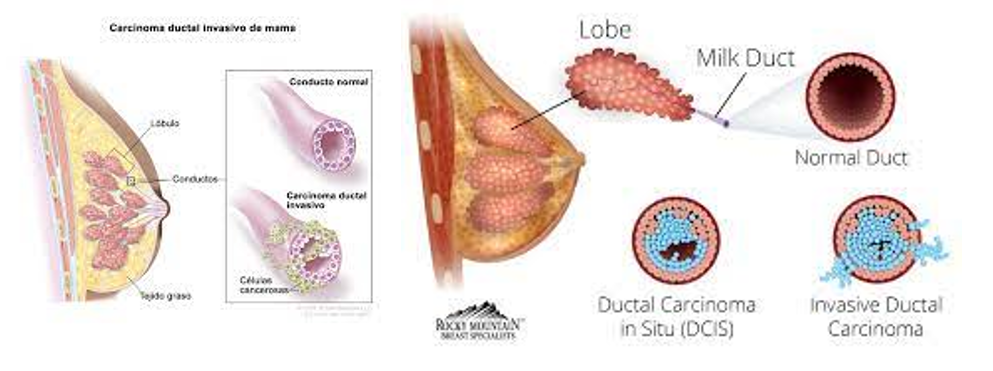

## 1.2 Objetivo de este trabajo

EL objetivo es crear y entrenar un modelo basado en redes neuronales para que pueda detectar y clasificar en base a unas imagenes de entrada si una persona tiene o no IDC (carcinoma ductal invasivo) 

## 1.3 Conjunto de datos de partida

El conjunto de datos inicial contiene imagenes de pacientes. Cada imagen esta descompuesta en parches, donde para cada paciente tenemos una carpeta "0" con los parches de imagenes que no contienen cancer y otra carpeta denominada "1" para los que si tienen. Y dentro de cada carpeta tenemos las imagenes 

El dataset utilizado es https://academictorrents.com/details/e40bd59ab08861329ce3c418be191651f35e2ffa

La estructura del nombre del archivo de cada imagen se compone por:
     Ejemplo "16551_idx5_x1351_y2501_class1"
*        Codigo del paciente_idx5
*        Posicion x de la imagen.
*        Posicion y de la imagen.
*        Clase (1 si tiene cancer y 0 en caso de no tener cancer)

# 2 ANALISIS EXPLORATORIO DE LOS DATOS (EDA)

## 2.1 Preparación y vistazo a la estructura de datos

En primer lugar importamos todas las librerías necesarias:

In [ ]:
!pip install Pillow
!pip install scikit-image
!pip install opencv-python
!pip install matplotlib
!pip install Scikit-learn
!pip install pandas
!pip install seaborn

In [1]:
import os
import numpy as np
import pandas as pd
import re
import glob
import cv2
import skimage
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io


In [2]:
#Esta función carga en la variable etiquetas todas las imágenes incluidas en las subcarpetas de la ruta indicada
def cargar_imagenes(ruta):
    dataset=[]
    paciente=0
    dataset=np.array(glob(ruta+'/**/*.png',recursive=True))
    
    patron=r".\\(\d+)\\.*_x(\d+)_y(\d+)_class(\d+)\.png"

    datos_imagen=[]
        
    for archivo in dataset:
        match=re.match(patron,archivo)
        if match:
            codigo_paciente=int(match.group(1))
            posicion_x=int(match.group(2))
            posicion_y=int(match.group(3))
            etiqueta=int(match.group(4))                
            datos_imagen.append([codigo_paciente,posicion_x,posicion_y,etiqueta,archivo])     

    datos_imagen=np.array(datos_imagen)               
    datos=pd.DataFrame(datos_imagen)
    datos.columns=['codigo_paciente','x','y','cancer','archivo']
    return datos

In [3]:
#Cargamos las imágenes con los datos
dataframe=cargar_imagenes('.')
dataset_cancer=np.array(dataframe)

In [4]:
#Esta función muestra los datos del dataset y las etiquetas
def analizar_dataset(dataset):
    positivo=0
    negativo=0
    j=0
    k=0
    for i in range(len(dataset)):    
        if int(dataset[i][3])==1:            
            positivo=positivo+1            
        else:            
            negativo=negativo+1
    print("Nº total de imágenes",len(dataset))
    print ("Nº positivos",positivo)
    print ("Nº negativos",negativo)
    imagen=io.imread(dataset[0][4])
    print("Tamaño de las imágenes",imagen.shape)

In [5]:
analizar_dataset(dataset_cancer)


Nº total de imágenes 277524
Nº positivos 78786
Nº negativos 198738
Tamaño de las imágenes (50, 50, 3)


Iniciamos la exploracion viendo cuantos imagenenes componen el conjunto de datos: 

In [6]:
dataframe.shape

(277524, 5)

Obtener informacion básica de los datos, estadisticas y nulos

In [7]:
# Codigo para mostrar el encabezado del conjunto de datos
dataframe.head()

codigo_paciente     x     y cancer  \
0           10253  1001  1001      0   
1           10253  1001  1051      0   
2           10253  1001  1101      0   
3           10253  1001  1151      0   
4           10253  1001  1201      0   

                                       archivo  
0  .\10253\0\10253_idx5_x1001_y1001_class0.png  
1  .\10253\0\10253_idx5_x1001_y1051_class0.png  
2  .\10253\0\10253_idx5_x1001_y1101_class0.png  
3  .\10253\0\10253_idx5_x1001_y1151_class0.png  
4  .\10253\0\10253_idx5_x1001_y1201_class0.png

In [8]:
# Ejemplo de codigo para mostrar el encabezado
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   codigo_paciente  277524 non-null  object
 1   x                277524 non-null  object
 2   y                277524 non-null  object
 3   cancer           277524 non-null  object
 4   archivo          277524 non-null  object
dtypes: object(5)
memory usage: 10.6+ MB


La informacion estadistica basica como puede ser el conteo de campos no nulos, la media ,...

In [9]:
# Ejemplo de codigo para mostrar la informacion basica
dataframe.describe()

codigo_paciente       x       y  cancer  \
count           277524  277524  277524  277524   
unique             279      81      60       2   
top              13693    1501    1001       0   
freq              2395    5944    8012  198738   

                                            archivo  
count                                        277524  
unique                                       277524  
top     .\10253\0\10253_idx5_x1001_y1001_class0.png  
freq                                              1

Vamos a realizar algunas representaciones gráficas para ver como son las distribuciones de los datos.

In [ ]:
print(dataframe.codigo_paciente.value_counts())

Ahora para cada paciente conocemos la ruta de cada parche, así como si contiene IDC o no (el objetivo).

## 2.1.1 Resumen
      
* Podemos observar que tenemos los datos de 279 pacientes. 
* En total tendremos 277524 imagenes de los pacientes, de los cuales 198.738 (71.63%) no tienen cancer y 78.785 (28.37%) si tienen cancer. 
* El tamaño de las imagenes es (50,50,3). 50 pixeles por 50 pixeles con 3 canales color RGB.



## 2.2 Analisis Exploratorio

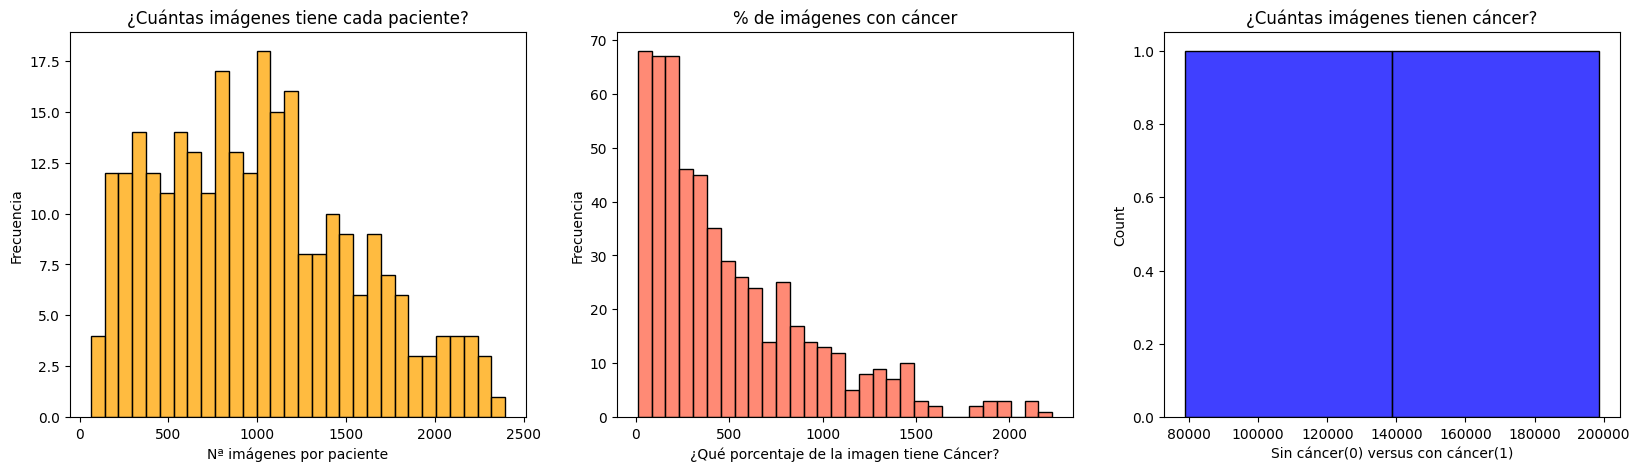

In [61]:
#Por favor, revisa esto (ALEJANDRO)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(dataframe.groupby("codigo_paciente").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Nª imágenes por paciente")
ax[0].set_ylabel("Frecuencia")
ax[0].set_title("¿Cuántas imágenes tiene cada paciente?")

sns.histplot(dataframe.groupby(["codigo_paciente","cancer"]).size(), ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_xlabel("¿Qué porcentaje de la imagen tiene Cáncer?")
ax[1].set_ylabel("Frecuencia")
ax[1].set_title("% de imágenes con cáncer")

sns.histplot(dataframe.groupby("cancer").size(), ax=ax[2], color='blue',kde=False,bins=2)
ax[2].set_xlabel("Sin cáncer(0) versus con cáncer(1)")
ax[2].set_title("¿Cuántas imágenes tienen cáncer?")

plt.show()



In [25]:
#print(dataframe.groupby("codigo_paciente")['cancer'].size())



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Y todo esto deberia dar algo similar a : 

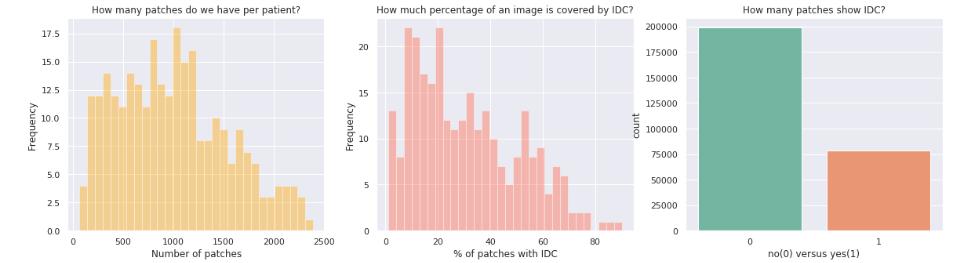

A continuacion vamos a ver un correolograma dado que nos permite analizar las relaciones entre cada par de variables numericas de nuestro conjunto de datos.

In [ ]:
#Codigo copiado del ejemplo de cancer de Kaggle, para poder usarlo como ejemplo

sns.pairplot(dataframe, vars=["x","y","cancer"], height=3,kind='scatter')

Y todo esto deberia dar algo similar a 

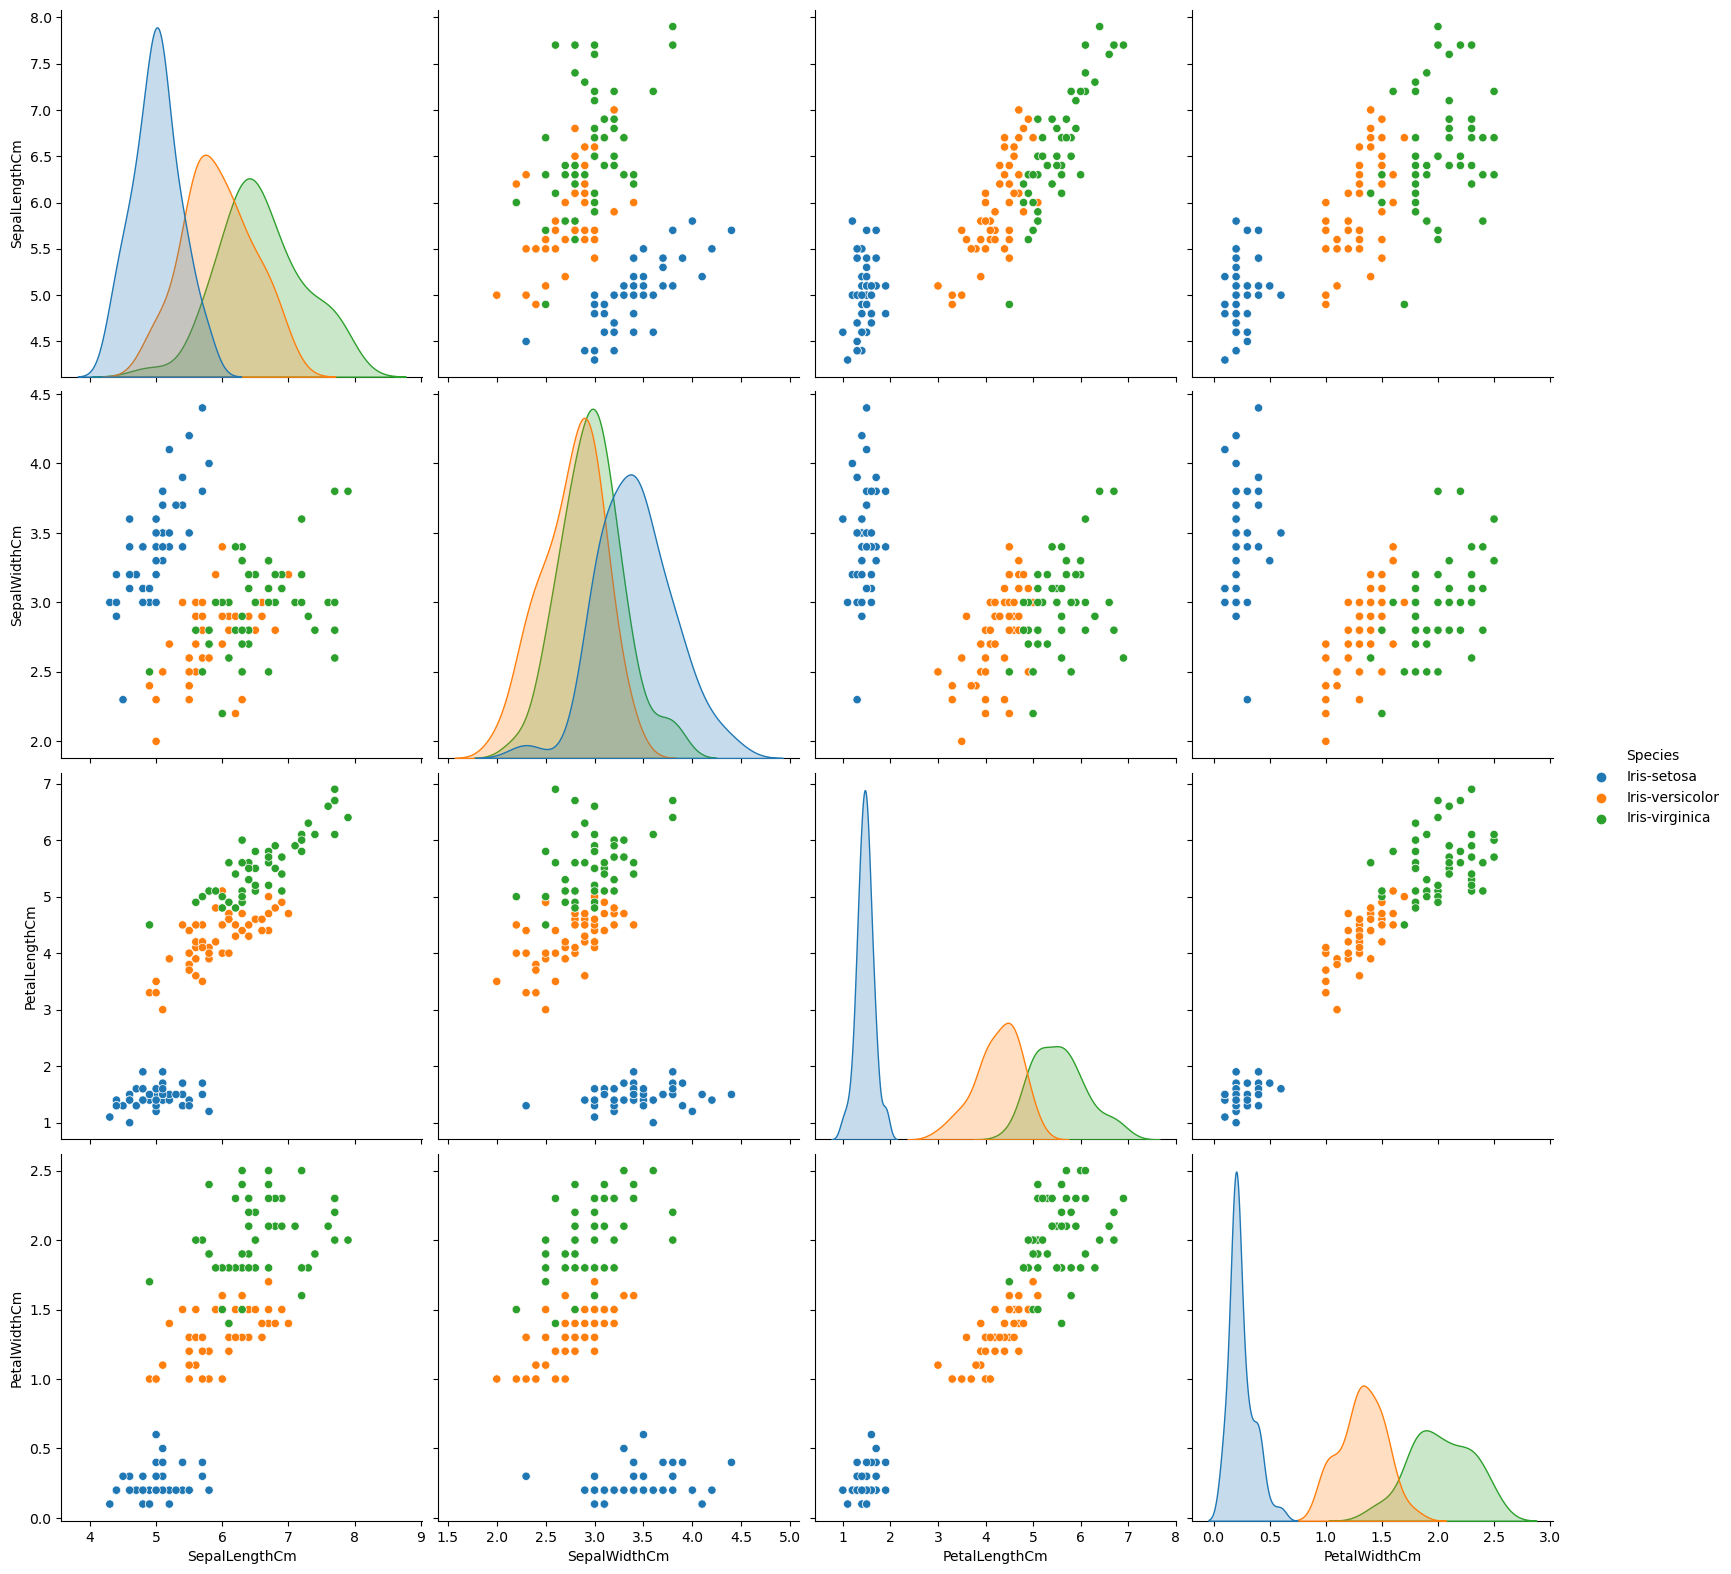

## Insights

* Podemos observar como el número de parches de imagen por paciente varía mucho. Esto plantea la duda de si todas las imágenes muestran la misma resolución de las células del tejido o si esto varía entre los pacientes.
* Algunos pacientes tienen más del 80 % de parches que muestran IDC
* Las clases de IDC versus no IDC están desequilibradas. Tenemos que verificar esto nuevamente después de configurar una estrategia de validación y encontrar una estrategia para lidiar con los pesos de clase (si queremos aplicarlos).
* EL numero de pacientes es pequeño en comparación con el número esperado de pacientes que uno quisiera analizar con nuestro algoritmo después de la implementación. En consecuencia, es muy probable que surja overfitting a esta distribución específica de pacientes y debemos tener cuidado con el rendimiento de generalización de nuestro modelo.
* Nuestro algoritmo necesita decidir si un parche de imagen contiene IDC o no. En consecuencia, no se debe considerar como entrada para nuestro algoritmo el corte completo del tejido del paciente, sino los parches individuales.
* Para alimentar el algoritmo con parches de imagen, sería bueno almacenar la ruta de cada imagen. De esta manera, podemos cargar lotes de imágenes solo una por una sin almacenar los valores de píxel de todas las imágenes.

Vamos a ver la distribucion de la muestra entre el conjunto de datos para entranamiento y test ( y validacion?)

In [ ]:
#PENDIENTE DE DIFERENTES MUESTRAS (ALEJANDRO)

fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.histplot(dataframe['cancer'].size(), ax=ax[0], palette="Reds")
ax[0].set_title("Train data")


Y este codigo daria una imagen similar a : 

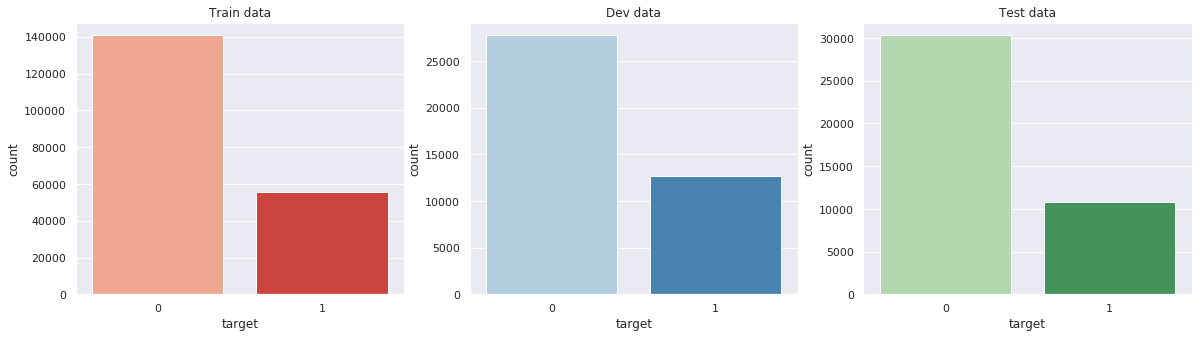

Vamos a mostrar imagenes de casos con IDC positivios y casos necgativos a modo de ejemplo. Para ello separamos las imágenes positivas de las negativas en dos dataset diferentes.

In [62]:
#NO SEPARA BIEN LOS DATOS (ALEJANDRO)

dataset_sin=[]
dataset_con=[]
dataset_sin = dataframe[dataframe['cancer']==0]
dataset_con = dataframe[dataframe['cancer']==1]

A continuación mostramos 50 imágenes aleatorias de cada grupo

KeyError: 0

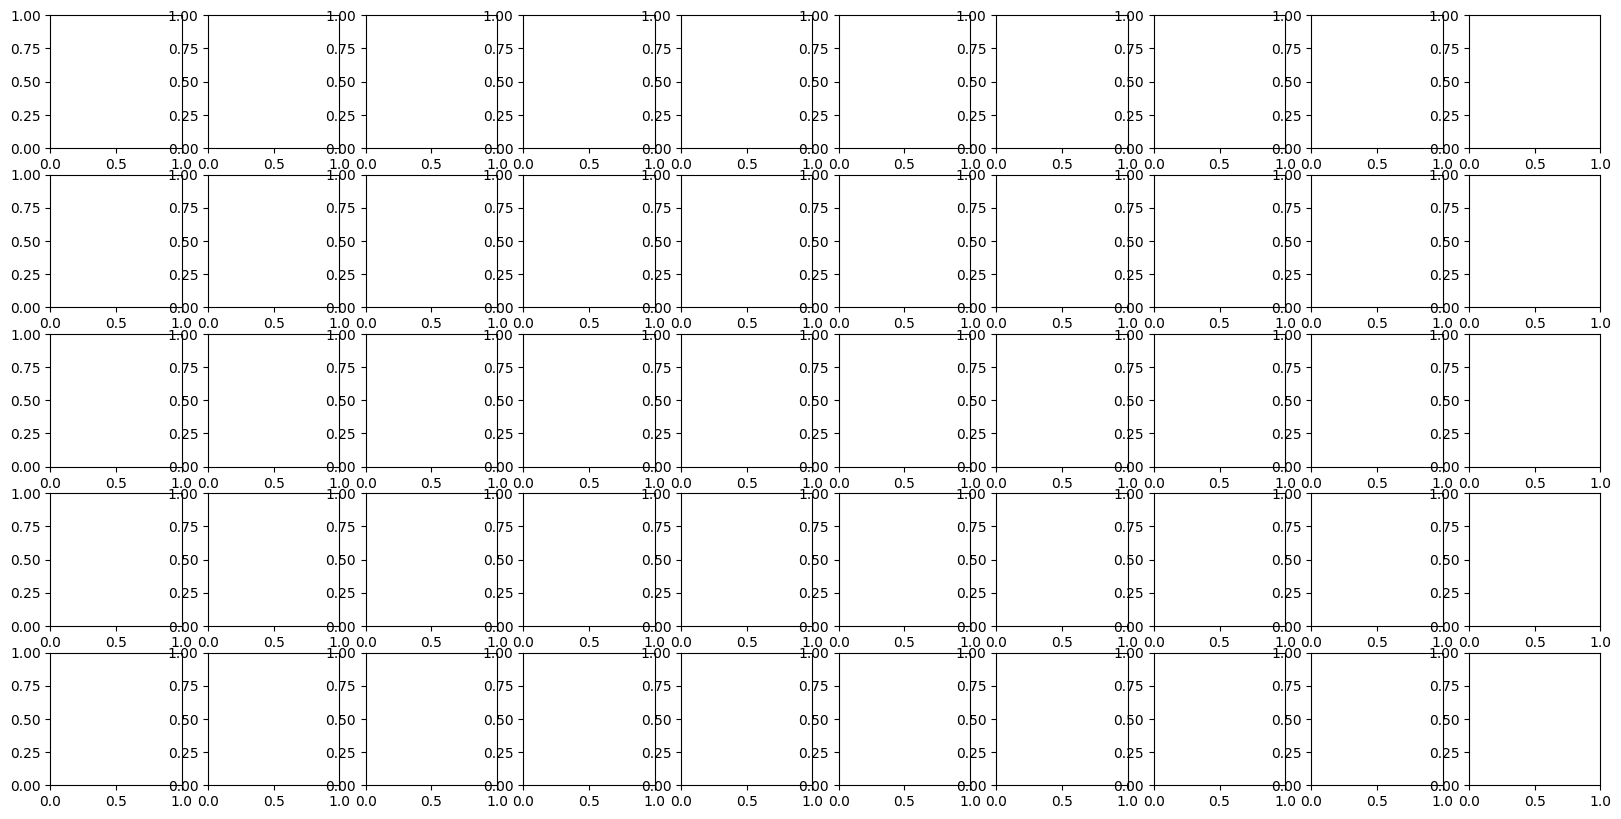

In [58]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = dataset_sin[m + 10*n]        
        image = Imread(idx["fichero"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Y todo esto deberia dar algo similar a : 

Casos con Cancer (IDC positivo)

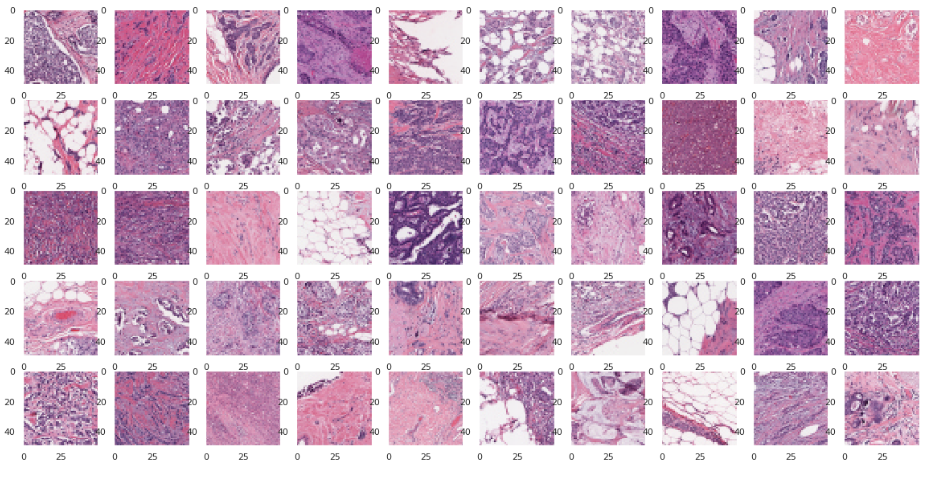

Casos sin cancer (IDC negativo)

In [ ]:
#Codigo copiado del ejemplo de cancer de Kaggle, para poder usarlo como ejemplo

fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

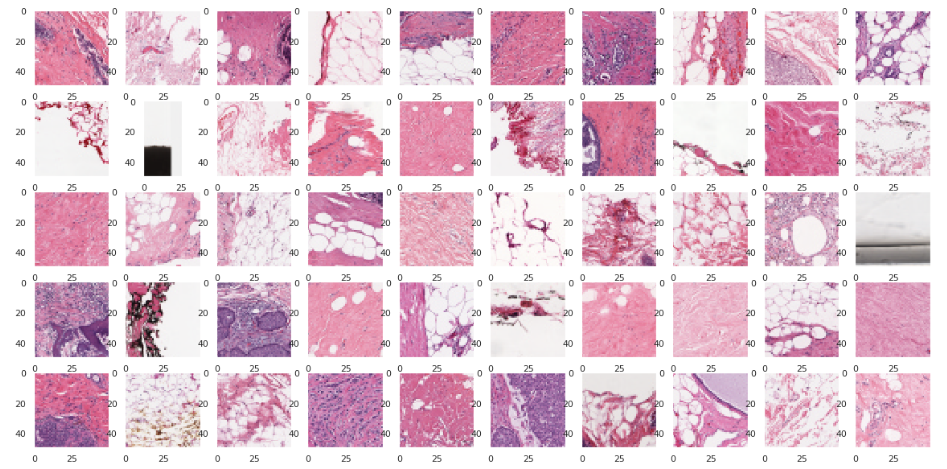

# Visualizacion del tejido mamario

Dentro del data frame tenemos las coordenadas de los parches de imagen que están almacenados en los nombres de las imágenes. Entonces podemos usar las coordenadas para reconstruir todo el tejido mamario de una paciente. De esta manera, también podemos explorar cómo se ve el tejido enfermo en comparación con los sanos.

Ahora tenemos las coordenadas de cada parche, su ruta para cargar la imagen y su información de destino.

# Visualización de objetivos binarios por corte de tejido

Antes de echar un vistazo a todo el tejido, hagámoslo un poco más simple observando la estructura objetivo en el espacio x-y para un puñado de pacientes:

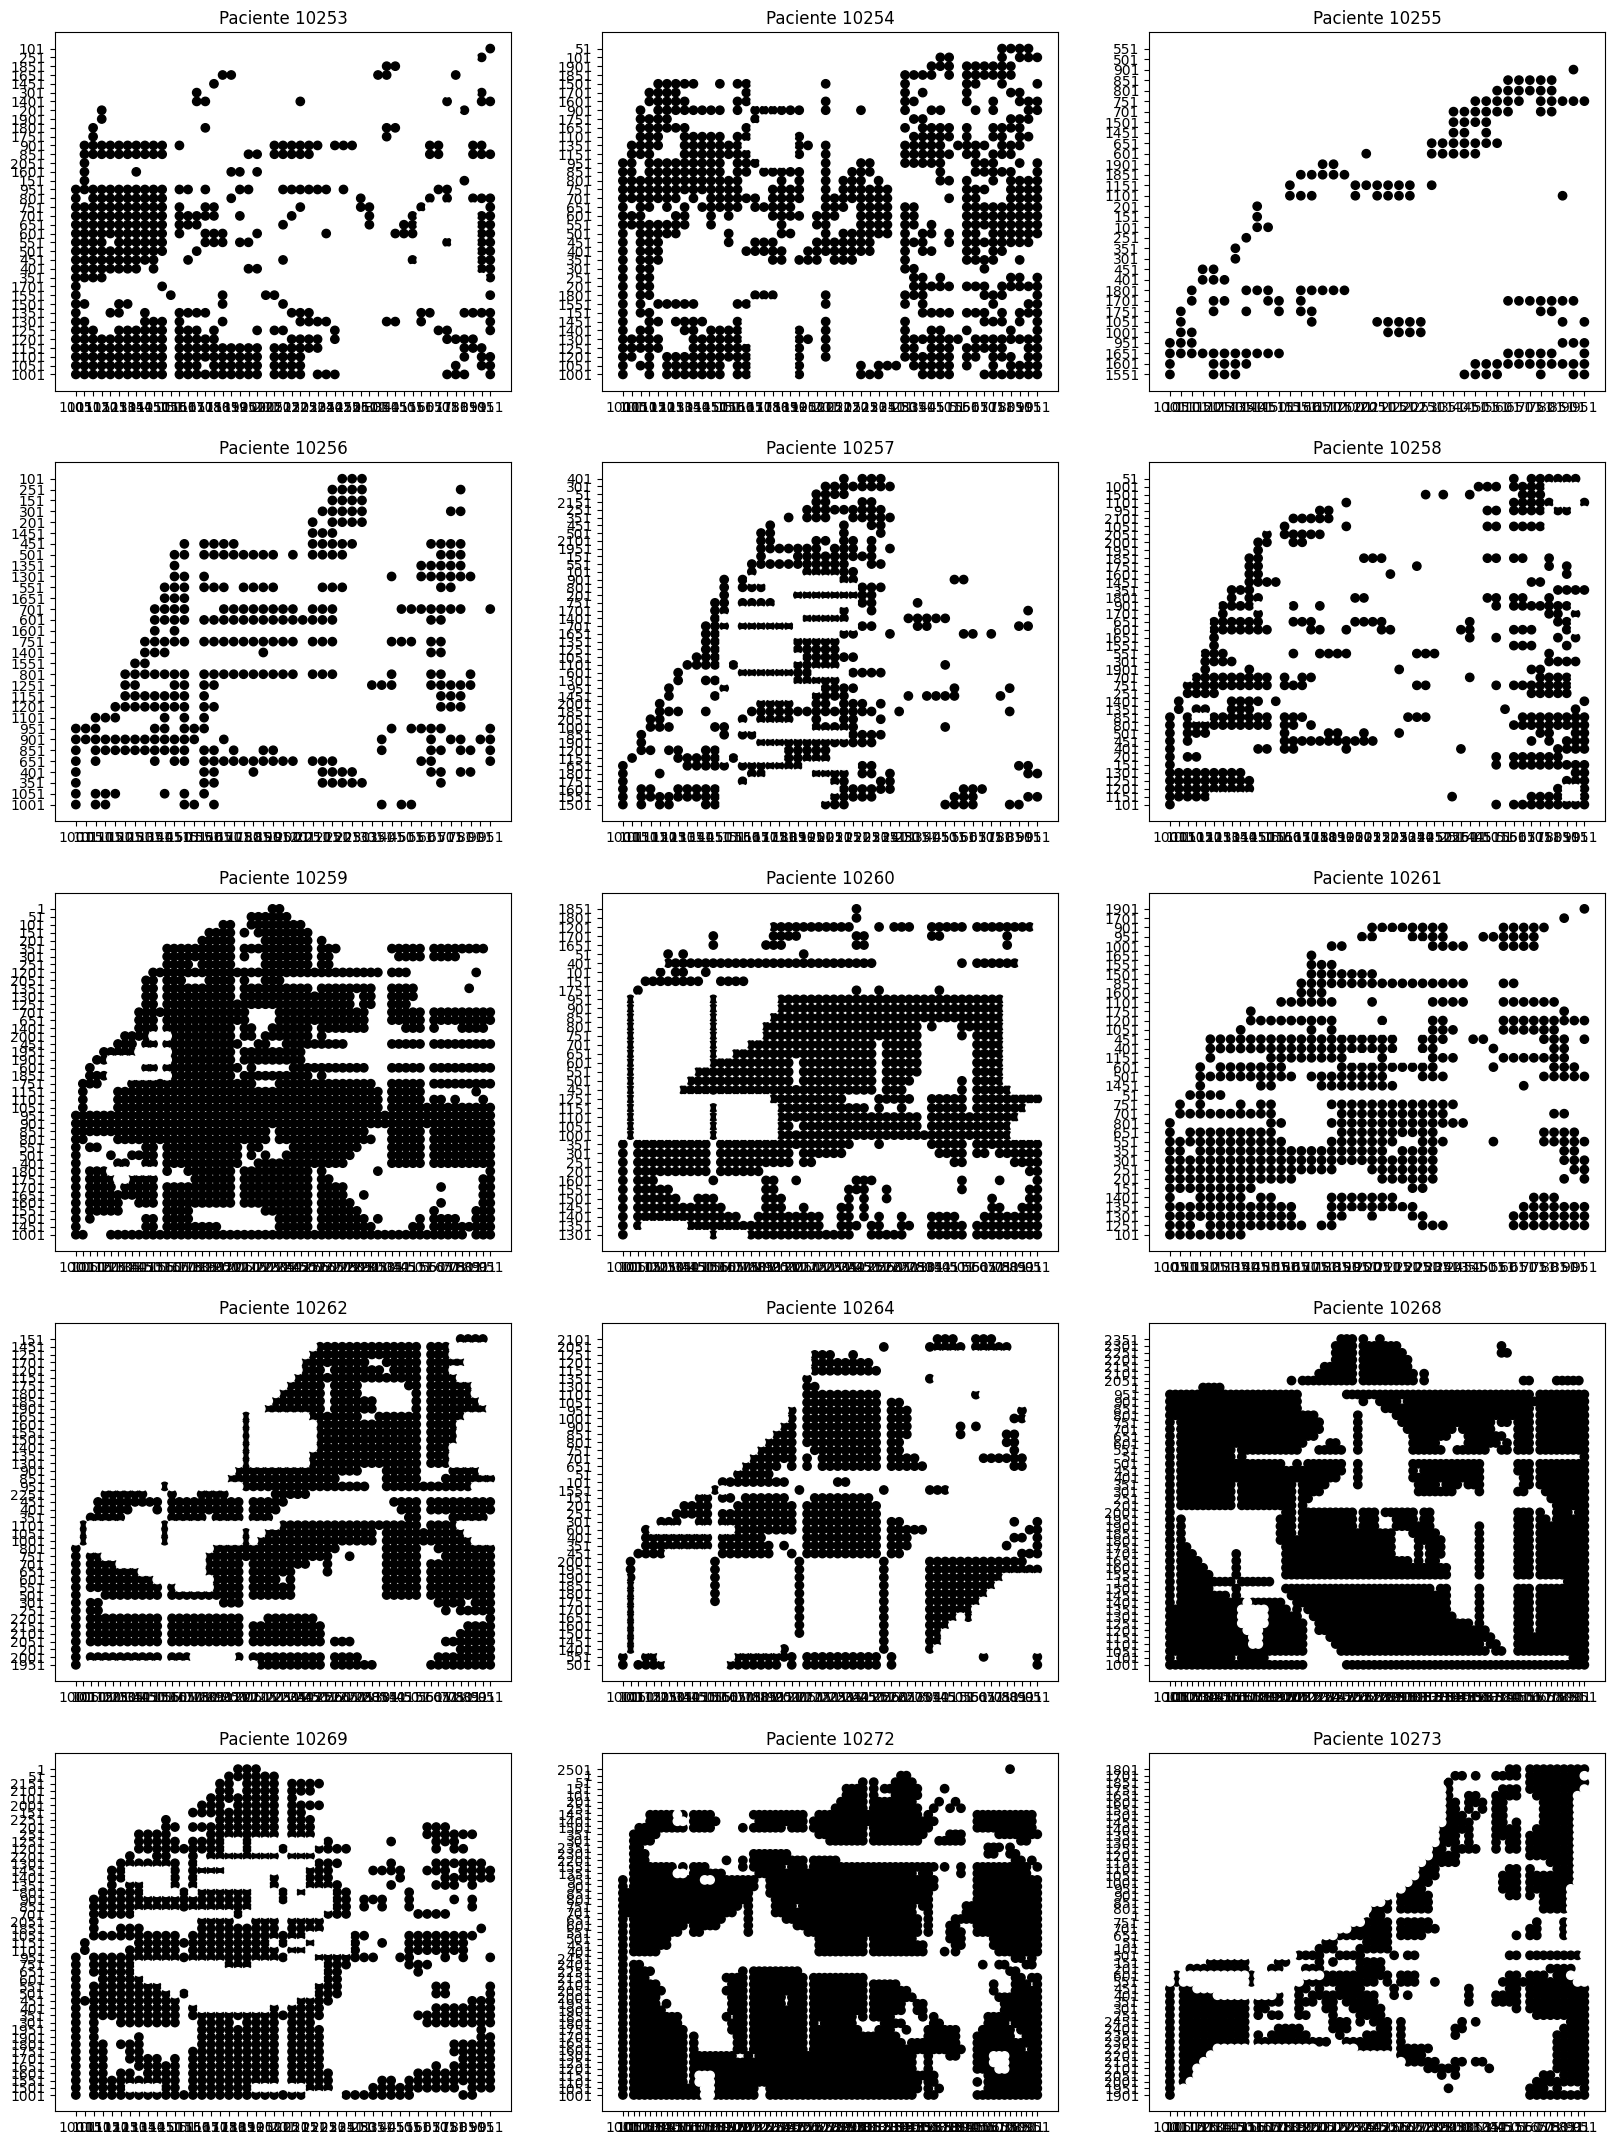

In [35]:
#AQUI HE TOCADO PARA REPRESENTAR LAS IMAGENES (NO CONSIGO CAMBIAR LOS COLORES)


#Codigo copiado del ejemplo de cancer de Kaggle, para poder usarlo como ejemplo

fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = dataframe.codigo_paciente.unique()

for n in range(5):
    for m in range(3):
        codigo_paciente = patient_ids[m + 3*n]        
        data_temporal = dataframe[dataframe['codigo_paciente']==codigo_paciente]    
        ax[n,m].scatter(data_temporal.x.values, data_temporal.y.values,c=data_temporal.cancer.values)
        ax[n,m].set_title("Paciente " + codigo_paciente)        

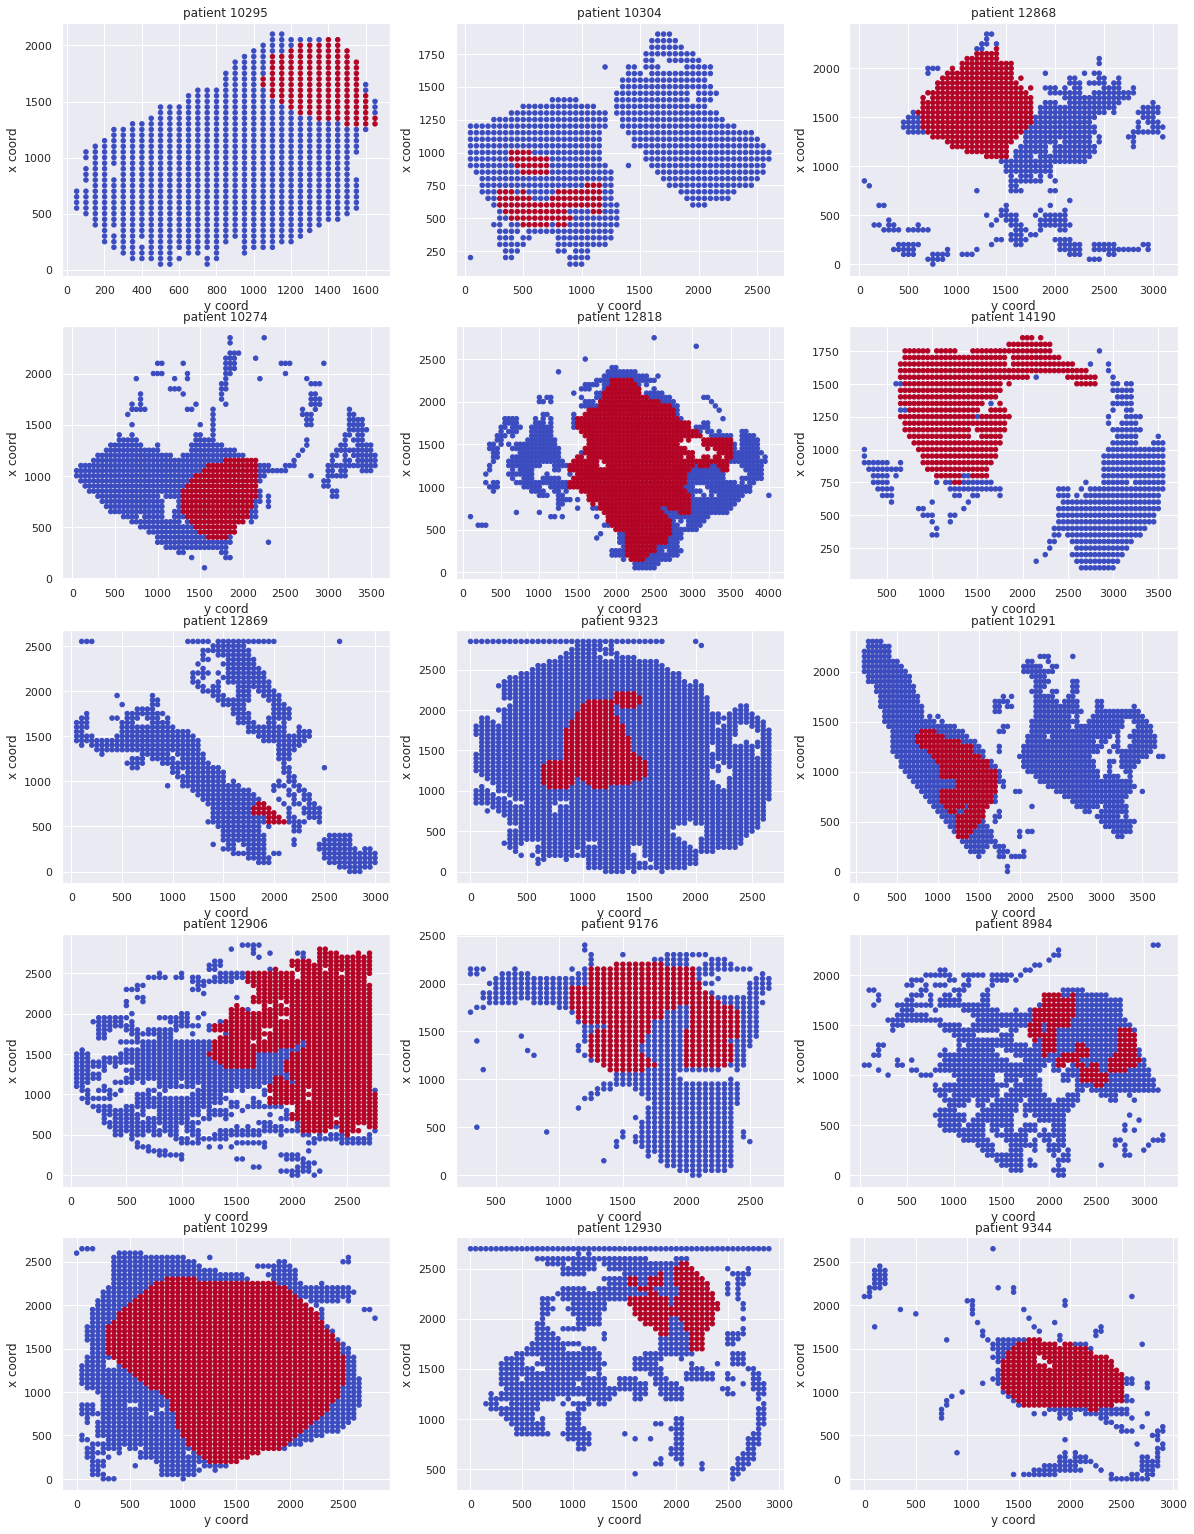

## Insight
EL reto que se nos plantea es como entrenar nuestro modelo para que pueda decidir si un parche de imagen contiene cancer o no. Es decir, no se debe considerar como entrada para nuestro modelo el corte completo del tejido del paciente, sino los parches individuales que si lo tengan.

# Visualización de las imágenes del tejido mamario
Dadas las coordenadas de los parches de imagen, vamos reconstruir toda la imagen del tejido (no solo los objetivos) de algunos pacientes.

In [ ]:
#Codigo copiado del ejemplo de cancer de Kaggle, para poder usarlo como ejemplo

def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

A modo de ejemplo tomaremos la muestra del paciente "13616" ( es un ejemplo)

In [ ]:
#Codigo copiado del ejemplo de cancer de Kaggle, para poder usarlo como ejemplo
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

Y este deberiamos tener una imagen similar a la siguiente

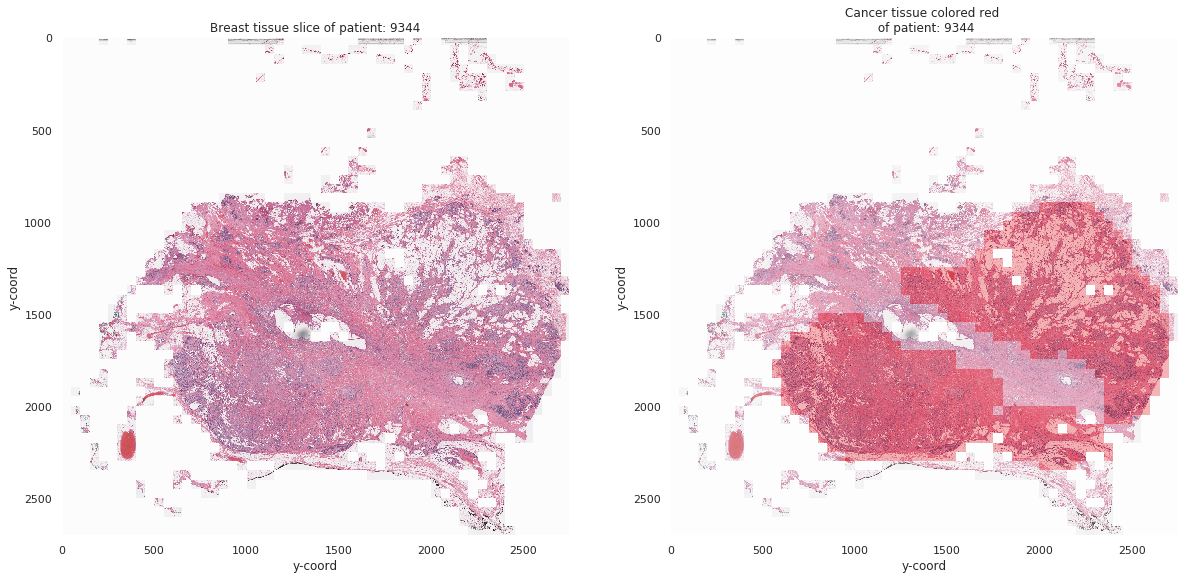

## FINAL DE LA PROPUESTA PARA EL ANALISIS EXPLORATIO DE LOS DATOS

# Preprocesamiento de los datos



*   Split en train, test, validation




In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dataset_cancer,etiquetas_cancer,random_state=0,test_size=0.2)

# Construcción de modelo base (BASELINE)

# Construcción de modelo CNN

## Rendimiento del modelo



*   Matriz de confusión
*   Rendimiento: accuracy. Loss: entropía binaria
*   Graficar la loss y el accuracy en cada iteración
*   Probar distintos parámetros hasta conseguir el mejor resultado (NO BORRAR LAS PRUEBAS ANTERIORES) 



# Comparación de modelos

# Prueba del modelo

# Pipeline end-to-end